<a href="https://colab.research.google.com/github/dlwub/Early-Detection-of-Parkinson-s-Diseases-Using-Voice-Data/blob/master/Early_Detection_of_Parkinson's_Diseases_Using_Voice_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#### Project description: This project involves the analysis of the UCI Parkinson's Dataset, which consists of two types of files: parkinsons.data and parkinsons_updrs.data. The Telemonitoring Parkinson’s Disease Dataset (found in the Telemonitoring folder) is an extended version of the basic Parkinson’s dataset. It includes additional biomedical voice measurements along with Unified Parkinson’s Disease Rating Scale (UPDRS) scores, which are clinically used to assess the severity of Parkinson’s disease.

#### In this project, we will perform classification analysis on the parkinsons.data file to distinguish between individuals with and without Parkinson’s disease.
#### We will conduct regression analysis on the parkinsons_updrs.data file to predict UPDRS scores based on biomedical voice measurements.
#### The aim of the project is to improve early diagnosis and severity assessment of Parkinson’s disease using machine learning techniques.


In [ ]:
!pip install xgboost scikit-learn pandas

#### Import necessary libraries

In [ ]:
import pandas as pd
import joblib
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.svm import SVC, SVR
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from xgboost import XGBClassifier, XGBRegressor, plot_importance

## Classification analysis to distinguish patients with Parkinson's disease and those without based on observed symptoms.
#### The goal is to leverage machine learning algorithms to analyze various symptom patterns and biomedical measurements in order to accurately distinguish between individuals with Parkinson’s disease and those without. This classification can play a crucial role in early diagnosis and intervention.

### Step 1. Load and read the data

In [ ]:
df = pd.read_csv("/content/gdrive/MyDrive/Parkinson's Dataset/parkinsons/parkinsons.data")
df.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,0.426,0.02182,0.03130,0.02971,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,0.626,0.03134,0.04518,0.04368,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,0.482,0.02757,0.03858,0.03590,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,0.517,0.02924,0.04005,0.03772,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,0.584,0.03490,0.04825,0.04465,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [ ]:
df.shape

(195, 24)

### Step 2. Data Preprocessing

In [ ]:
# Check for missing values
print(df.isnull().sum())

name                0
MDVP:Fo(Hz)         0
MDVP:Fhi(Hz)        0
MDVP:Flo(Hz)        0
MDVP:Jitter(%)      0
MDVP:Jitter(Abs)    0
MDVP:RAP            0
MDVP:PPQ            0
Jitter:DDP          0
MDVP:Shimmer        0
MDVP:Shimmer(dB)    0
Shimmer:APQ3        0
Shimmer:APQ5        0
MDVP:APQ            0
Shimmer:DDA         0
NHR                 0
HNR                 0
status              0
RPDE                0
DFA                 0
spread1             0
spread2             0
D2                  0
PPE                 0
dtype: int64


In [ ]:
# Drop the name column, it is not needed for model training
df.drop(columns=["name"], inplace=True)

### Step 3. Feature Engineering

In [ ]:
scaler = MinMaxScaler()
# Scale all columns except the target column
df.iloc[:, :-1] = scaler.fit_transform(df.iloc[:, :-1])

### Step 4. Split the data

In [ ]:
X = df.drop(columns=['status'])
y = df['status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Step 5. Train models

#### Let's start with Random Forest Classifier

In [ ]:
# Train the model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_pred, y_test))
print("Classification Report:", classification_report(y_pred, y_test))

Accuracy: 0.9230769230769231
Classification Report:               precision    recall  f1-score   support

           0       0.80      0.89      0.84         9
           1       0.97      0.93      0.95        30

    accuracy                           0.92        39
   macro avg       0.88      0.91      0.90        39
weighted avg       0.93      0.92      0.92        39



### Analysis of the Random Forest Classifier
**Class 0 (Healthy):** Precision = **80%**, Recall = **89%**, F1-score = **84%**

**Class 1 (Parkinson’s):** Precision = **97%**, Recall = **93%**, F1-score = **95%**

**Overall Accuracy:** **92.3%**

**Macro Average (Unweighted):** F1-score = **90%**

**Weighted Average** **(Accounts for Class Imbalance):** F1-score = **92%**

### Overall accuracy of 92.3% is an excellent score. Let's tune the hyperparameters for better results.

In [ ]:
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [5, 10, None],
    "min_samples_split": [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
best_model_rf = grid_search.best_estimator_

Best parameters: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100}


#### Let's predict using the best model

In [ ]:
y_prediction = best_model_rf.predict(X_test)

print("Accuracy:", accuracy_score(y_prediction, y_test))
print("Classification Report:", classification_report(y_prediction, y_test))

Accuracy: 0.9230769230769231
Classification Report:               precision    recall  f1-score   support

           0       0.80      0.89      0.84         9
           1       0.97      0.93      0.95        30

    accuracy                           0.92        39
   macro avg       0.88      0.91      0.90        39
weighted avg       0.93      0.92      0.92        39



#### There is no improvement in the accuracy scores.

In [ ]:
# Save the model
joblib.dump(best_model_rf, 'random_forest_best_model.pkl')

['random_forest_best_model.pkl']

### Feature importance analysis

In [ ]:
# Extract feature importances
feature_importances = best_model_rf.feature_importances_

# Create a dataframe to map feature names to their importance values
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Sort the dataframe by importance
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

print(feature_importance_df)

             Feature  Importance
21               PPE    0.162080
18           spread1    0.112107
0        MDVP:Fo(Hz)    0.066995
14               NHR    0.062056
2       MDVP:Flo(Hz)    0.059495
7         Jitter:DDP    0.056434
1       MDVP:Fhi(Hz)    0.050225
19           spread2    0.042110
5           MDVP:RAP    0.040777
11      Shimmer:APQ5    0.039598
20                D2    0.036098
13       Shimmer:DDA    0.031082
12          MDVP:APQ    0.028825
8       MDVP:Shimmer    0.028641
10      Shimmer:APQ3    0.027592
4   MDVP:Jitter(Abs)    0.026721
6           MDVP:PPQ    0.025844
15               HNR    0.023501
16              RPDE    0.022151
3     MDVP:Jitter(%)    0.020998
9   MDVP:Shimmer(dB)    0.018401
17               DFA    0.018268


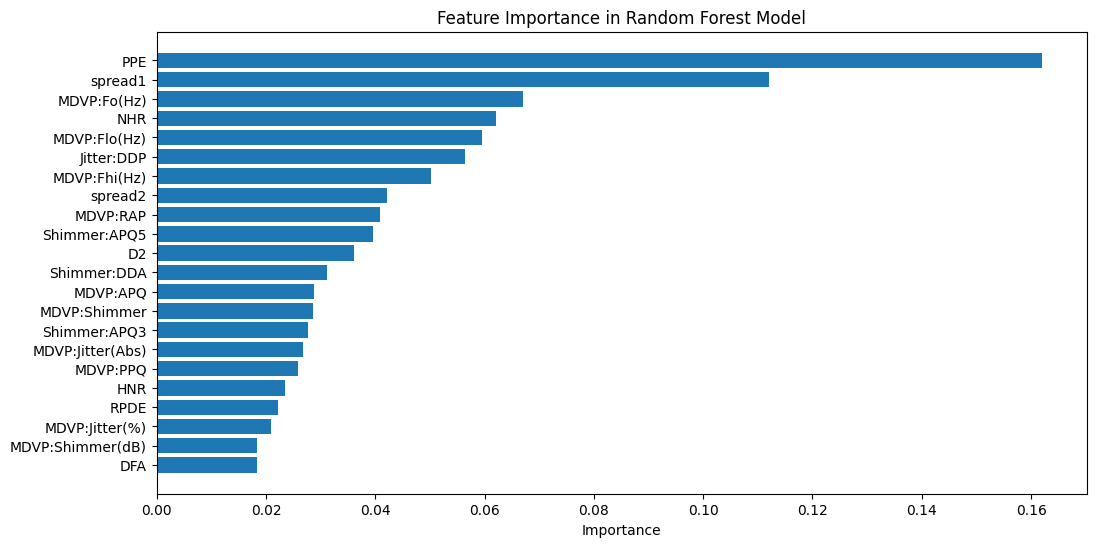

In [ ]:
# Plot feature importance
plt.figure(figsize=(12, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel("Importance")
plt.title("Feature Importance in Random Forest Model")
plt.gca().invert_yaxis()
plt.show()

### Feature Selection
#### Let's use only the top k most important features to improve the model
#### How to determine k? Let's use **Cross-Validation** to find best k.

In [ ]:
# Define a function that implements Cross-Validation
def cross_validation(model):
  best_k = 1
  best_score = 0

  for k in range(1, X.shape[1] + 1):
    top_k_features = X_train.columns[np.argsort(feature_importances)[-k:]]
    scores = cross_val_score(model, X_train[top_k_features], y_train, cv=5, scoring='accuracy')
    mean_score = np.mean(scores)

    if mean_score > best_score:
      best_score = mean_score
      best_k = k
  return best_k, best_score

In [ ]:
best_k, best_score = cross_validation(best_model_rf)
print(f"Optimal k: {best_k}, optimal score: {best_score}")

Optimal k: 11, optimal score: 0.9171370967741936


### We take the top 11 most important features and train the model, predict and evaluate it.

In [ ]:
top_11_features = X_train.columns[np.argsort(feature_importances)[-11:]]

# Train model with selected features
best_model_rf.fit(X_train[top_11_features], y_train)

# Predict
y_pred_rf = best_model_rf.predict(X_test[top_11_features])

print("Accuracy:", accuracy_score(y_pred_rf, y_test))
print("Classification Report:", classification_report(y_pred_rf, y_test))

Accuracy: 0.8974358974358975
Classification Report:               precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.93      0.93      0.93        29

    accuracy                           0.90        39
   macro avg       0.87      0.87      0.87        39
weighted avg       0.90      0.90      0.90        39



#### Feature selection did not improve the model's performance. The model without feature selection achieved better accuracy and overall classification performance. This suggests that, for this dataset, feature selection may not be necessary, and the model already utilizes the most relevant features effectively.

### Let's try another model: Support Vector Machines (SVM)

In [ ]:
svm_model = SVC(kernel='rbf', C=1.0)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

print("SVM accuracy:", accuracy_score(y_test, y_pred_svm))
print("Classification Report:", classification_report(y_test, y_pred_svm))

SVM accuracy: 0.8974358974358975
Classification Report:               precision    recall  f1-score   support

           0       1.00      0.60      0.75        10
           1       0.88      1.00      0.94        29

    accuracy                           0.90        39
   macro avg       0.94      0.80      0.84        39
weighted avg       0.91      0.90      0.89        39



### The accuracy of SVM (89%) is lower than the Random Forest (92.3%). Also the F-1 score of class 0 (75%) is much lower than that of the Random Forest (84%). Let's try to improve the SVM by tuning the hyperparameters.

In [ ]:
# Define parameter grid
param_grid = {
    'kernel': ['linear', 'rbf', 'poly'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1]
}

grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best hyperparameters
print(grid_search.best_params_)

# Train best model
svm_best_model = grid_search.best_estimator_

# Predict best model
y_pred_best_model = svm_best_model.predict(X_test)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
{'C': 100, 'gamma': 1, 'kernel': 'rbf'}


#### Accuracy scores on the best model

In [ ]:
print("Accuracy Score:", accuracy_score(y_pred_best_model, y_test))
print('Classification Report:', classification_report(y_pred_best_model, y_test))

Accuracy Score: 0.8974358974358975
Classification Report:               precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.93      0.93      0.93        29

    accuracy                           0.90        39
   macro avg       0.87      0.87      0.87        39
weighted avg       0.90      0.90      0.90        39



### Analysis of the Tuned SVM Results
**Accuracy:** 89.7% → 90% (Slight Improvement)

**Class 0 (Healthy) F1-score:** 75% → 80% (Better but still lower than RandomForest)

**Class 1 (Parkinson’s) F1-score:** 94% → 93% (Still strong)

**Macro Avg F1-score:** 84% → 87% (Improved balance between classes)

**Conclusion: Random Forest still performs better than SVM**

### Feature selection
#### Let's perform feature selection to improve the SVM model

In [ ]:
best_k, best_score = cross_validation(svm_best_model)
print(f"Optimal k: {best_k}, optimal score: {best_score}")

Optimal k: 19, optimal score: 0.9360887096774194


In [ ]:
top_19_features = X_train.columns[np.argsort(feature_importances)[-19:]]

# Train model with selected features
svm_best_model.fit(X_train[top_19_features], y_train)

# Predict
y_pred_svm = svm_best_model.predict(X_test[top_19_features])

print("Accuracy:", accuracy_score(y_pred_svm, y_test))
print("Classification Report:", classification_report(y_pred_svm, y_test))

Accuracy: 0.8974358974358975
Classification Report:               precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.93      0.93      0.93        29

    accuracy                           0.90        39
   macro avg       0.87      0.87      0.87        39
weighted avg       0.90      0.90      0.90        39



#### Model selection didn't result in significan improvement in the accuracy scores. The accuracy, precision, recall and f1-score remain the same. This suggests the dataset doesn't require further dimensionality reduction.

### XGBoost

In [ ]:
# Train an XGBoost model
xgb_model = XGBClassifier(
    use_label_encoder = False,
    eval_metric="logloss",
    n_estimators=50,
    max_depth=2,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8
)

xgb_model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:25:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_pred = xgb_model.predict(X_test)
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Classification Report:", classification_report(y_test, y_pred))

Accuracy Score: 0.8974358974358975
Classification Report:               precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.93      0.93      0.93        29

    accuracy                           0.90        39
   macro avg       0.87      0.87      0.87        39
weighted avg       0.90      0.90      0.90        39



#### Let's tune hyperparameters

In [ ]:
# Let's start with Random Search CV
# Define parameter distribution
param_dist = {
    'max_depth': np.arange(3, 10, 2),
    'learning_rate': np.linspace(0.01, 0.3, 5),
    'n_estimators': np.arange(50, 500, 50),
    'subsample': np.linspace(0.5, 1.0, 5),
    'colsample_bytree': np.linspace(0.5, 1.0, 5)
}

# Perform Randomized Search
randomized_search = RandomizedSearchCV(xgb_model, param_dist, n_iter=20, scoring='accuracy', cv=5, n_jobs=-1, random_state=42)
randomized_search.fit(X_train, y_train)

xgb_best_model = randomized_search.best_estimator_

# Best parpameters and accuracy
print("Best parameters:", randomized_search.best_params_)
print("Best Score:", randomized_search.best_score_)

Best parameters: {'subsample': 0.625, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.155, 'colsample_bytree': 0.5}
Best Score: 0.9231854838709678


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:25:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
# Predict on the best XGB model
y_pred_best = xgb_best_model.predict(X_test)
print("Accuracy Score:", accuracy_score(y_test, y_pred_best))
print("Classification Report:", classification_report(y_test, y_pred_best))

Accuracy Score: 0.9230769230769231
Classification Report:               precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.93      0.97      0.95        29

    accuracy                           0.92        39
   macro avg       0.91      0.88      0.90        39
weighted avg       0.92      0.92      0.92        39



### The model has achieved the same accuracy level (92.3%) as the Random Forest model and it has become better than the Random Forest model in the precision and f1-score of class 1 and recall of class 2.

#### Let's check feature importance

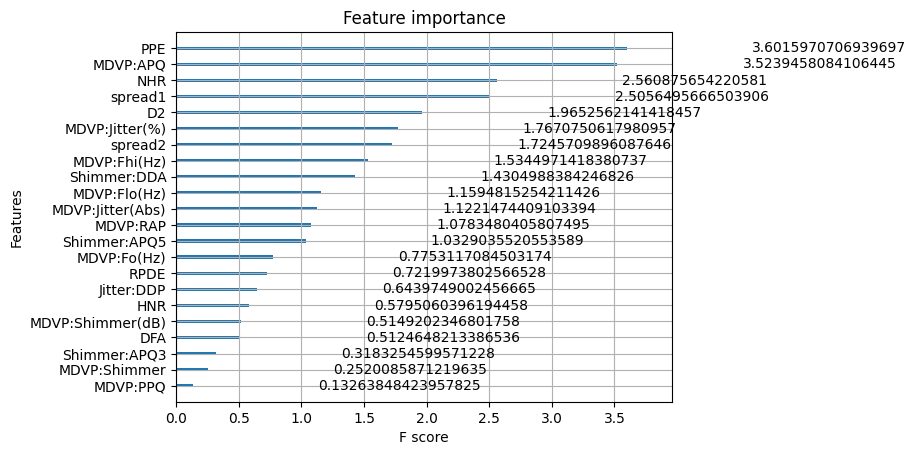

In [ ]:
plot_importance(xgb_best_model, importance_type='gain')
plt.show()

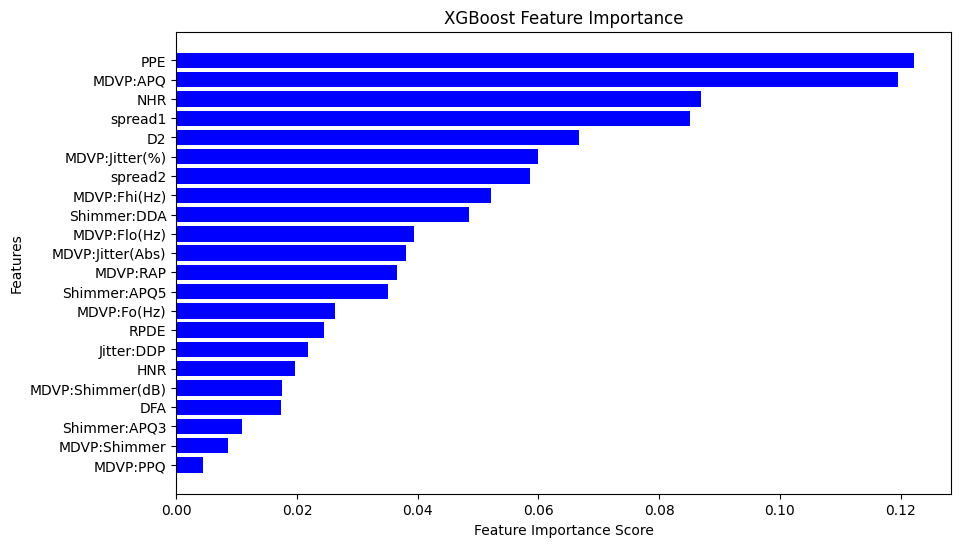

In [ ]:
# Alternatively we can use feature_importances_
feature_importance = xgb_best_model.feature_importances_

# Create a dataframe for visualization
feat_importance_df = pd.DataFrame({"Feature": X_train.columns, "Importance": feature_importance})
feat_importance_df = feat_importance_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feat_importance_df['Feature'], feat_importance_df['Importance'], color='blue')
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("XGBoost Feature Importance")
plt.gca().invert_yaxis()
plt.show()

### Let's try if feature selection improves the XGBoost model

In [ ]:
best_k, best_score = cross_validation(xgb_best_model)
print(f"Optimal k: {best_k}, optimal score: {best_score}")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:25:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:25:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:25:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:25:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:25:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Optimal k: 22, optimal score: 0.9231854838709678


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:25:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:25:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


#### The optimal k is 22, i.e all features are important and dimensionality reduction is not required.

## Regression analysis to predict the severity of Parkinson's disease based on the Unified Parkinson’s Disease Rating Scale (UPDRS) score.
#### The goal is to develop a predictive model that estimates the level of disease progression and motor impairment by analyzing key features from biomedical measurements. This can aid in better monitoring and personalized treatment strategies for Parkinson’s patients.

### Step 1. Load and read the data

In [ ]:
df_updrs = pd.read_csv("/content/gdrive/MyDrive/Parkinson's Dataset/parkinsons/telemonitoring/parkinsons_updrs.data")

In [ ]:
df_updrs.head()

,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,1,72,0,5.6431,28.199,34.398,0.00662,0.000034,0.00401,0.00317,0.01204,0.02565,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006
1,1,72,0,12.6660,28.447,34.894,0.00300,0.000017,0.00132,0.00150,0.00395,0.02024,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810
2,1,72,0,19.6810,28.695,35.389,0.00481,0.000025,0.00205,0.00208,0.00616,0.01675,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014
3,1,72,0,25.6470,28.905,35.810,0.00528,0.000027,0.00191,0.00264,0.00573,0.02309,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277
4,1,72,0,33.6420,29.187,36.375,0.00335,0.000020,0.00093,0.00130,0.00278,0.01703,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361


### Step 2. Data preprocessing

In [ ]:
# Check for missing values
print(df_updrs.isnull().sum())

subject#         0
age              0
sex              0
test_time        0
motor_UPDRS      0
total_UPDRS      0
Jitter(%)        0
Jitter(Abs)      0
Jitter:RAP       0
Jitter:PPQ5      0
Jitter:DDP       0
Shimmer          0
Shimmer(dB)      0
Shimmer:APQ3     0
Shimmer:APQ5     0
Shimmer:APQ11    0
Shimmer:DDA      0
NHR              0
HNR              0
RPDE             0
DFA              0
PPE              0
dtype: int64


In [ ]:
# Drop subject# and test_time columns
df_updrs.drop(columns=['subject#', 'test_time'], inplace=True)

### Step 3. Feature Engineering and data splitting

In [ ]:
# Standardize
scaler = StandardScaler()

# Separate features and target variables
X = df_updrs.drop(columns=['motor_UPDRS', 'total_UPDRS']) # features
y_motor = df_updrs['motor_UPDRS'] # target 1
y_total = df_updrs['total_UPDRS'] # target 2

# Split into training and test sets
X_train, X_test, y_train_motor, y_test_motor, y_train_total, y_test_total = train_test_split(X, y_motor, y_total, test_size=0.2, random_state=42)

# Scale the features
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Step 4. Training models
#### Linear Regression to predict Motor UPDRS

In [ ]:
# Define model, train and predict
lr = LinearRegression()
lr.fit(X_train, y_train_motor)
y_pred_motor = lr.predict(X_test)

# Model evaluation
print("Linear Regression - Motor UPDRS")
print("Mean Squared Error:", mean_squared_error(y_test_motor, y_pred_motor))
print("Mean Absolute Error:", mean_absolute_error(y_test_motor, y_pred_motor))
print("R2 score:", r2_score(y_test_motor, y_pred_motor))

Linear Regression - Motor UPDRS
Mean Squared Error: 56.39158741356708
Mean Absolute Error: 6.365379135828523
R2 score: 0.11652402737521783


#### Linear Regression to predict Total UPDRS

In [ ]:
# Train model and predict
lr.fit(X_train, y_train_total)
y_pred_total = lr.predict(X_test)

# Model evaluation
print("Linear Regression - Total UPDRS")
print("Mean Squared Error:", mean_squared_error(y_test_total, y_pred_total))
print("Mean Absolute Error:", mean_absolute_error(y_test_total, y_pred_total))
print("R2 score:", r2_score(y_test_total, y_pred_total))

Linear Regression - Total UPDRS
Mean Squared Error: 94.11370054462343
Mean Absolute Error: 8.033620235522834
R2 score: 0.15069834990397468


#### Random Forest Regressor to predict Motor UPDRS

In [ ]:
# Define model, train, and predict
rf = RandomForestRegressor(n_estimators = 100, random_state=42)
rf.fit(X_train, y_train_motor)
y_pred_motor_rf = rf.predict(X_test)

# Model evaluation
print("Random Forest Regression - Motor UPDRS")
print("Mean Squared Error:", mean_squared_error(y_test_motor, y_pred_motor_rf))
print("Mean Absolute Error:", mean_absolute_error(y_test_motor, y_pred_motor_rf))
print("R2 score:", r2_score(y_test_motor, y_pred_motor_rf))

Random Forest Regression - Motor UPDRS
Mean Squared Error: 5.701733862663337
Mean Absolute Error: 1.7485232817021275
R2 score: 0.9106720505485855


#### Random Forest Regressor to predict Total UPDRS

In [ ]:
# Train model and predict
rf.fit(X_train, y_train_total)
y_pred_total_rf = rf.predict(X_test)

# Model evaluation
print("Random Forest Regression - Total UPDRS")
print("Mean Squared Error:", mean_squared_error(y_test_total, y_pred_total_rf))
print("Mean Absolute Error:", mean_absolute_error(y_test_total, y_pred_total_rf))
print("R2 score:", r2_score(y_test_total, y_pred_total_rf))

Random Forest Regression - Total UPDRS
Mean Squared Error: 8.774229426419108
Mean Absolute Error: 2.1447220834042557
R2 score: 0.9208195248188594


### Support Vector Regressor to predict Motor UPDRS

In [ ]:
# Define scaler
y_scaler = StandardScaler()

# Fit and transform target columns
y_train_motor_scaled = y_scaler.fit_transform(y_train_motor.values.reshape(-1, 1))
y_test_motor_scaled = y_scaler.transform(y_test_motor.values.reshape(-1, 1))

# Define and train model
svr = SVR(kernel='rbf', C=10, gamma='scale')
svr.fit(X_train, y_train_motor_scaled.ravel())

# Predict and inverse transform
y_pred_scaled = svr.predict(X_test)
y_pred_motor_svr = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))

# Model evaluation
print("Support Vector Regression - Motor UPDRS")
print("Mean Squared Error:", mean_squared_error(y_test_motor, y_pred_motor_svr))
print("Mean Absolute Error:", mean_absolute_error(y_test_motor, y_pred_motor_svr))
print("R2 score:", r2_score(y_test_motor, y_pred_motor_svr))

Support Vector Regression - Motor UPDRS
Mean Squared Error: 27.774680794340565
Mean Absolute Error: 4.029759136087952
R2 score: 0.5648595073381584


### Support Vector Regressor to predict Total UPDRS

In [ ]:
# Fit and transform target columns
y_train_total_scaled = y_scaler.fit_transform(y_train_total.values.reshape(-1, 1))
y_test_total_scaled = y_scaler.transform(y_test_total.values.reshape(-1, 1))

# Define and train model
svr.fit(X_train, y_train_total_scaled.ravel())

# Predict and inverse transform
y_pred_scaled = svr.predict(X_test)
y_pred_total_svr = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))

# Model evaluation
print("Support Vector Regression - Total UPDRS")
print("Mean Squared Error:", mean_squared_error(y_test_total, y_pred_total_svr))
print("Mean Absolute Error:", mean_absolute_error(y_test_total, y_pred_total_svr))
print("R2 score:", r2_score(y_test_total, y_pred_total_svr))

Support Vector Regression - Total UPDRS
Mean Squared Error: 48.2308877865732
Mean Absolute Error: 5.163209977171827
R2 score: 0.564754415715375


### Random Forest Regressor outperforms the linear regression and the SVR models. Tuning hyperparameters may result in better performance of the SVR and Random Forest Regressor.